**BraTS 2020 Dataset**

1. There are 369 enteries each having 5 different nii images
2. Multimodal scans available in NIfTI files (.nii)
3. There are 4 channels of information- 
* Native (T1)
* Post-contrast T1- weighted (T1CE) 
* T2-weighted (T2)
* T2 Fluid Attenuated Inversion Recovery (FLAIR)
4. In the mask image we have label 0,1,2,4 (3 is missing)

In [74]:
#Installing/Importing all the necessary libraries
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.utils import to_categorical
from tifffile import imsave
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [75]:
import nibabel as nib
TRAIN_DATASET_PATH=r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData'
img_1=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_flair.nii').get_fdata()
print(img_1.max())
img_2=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t1.nii').get_fdata()
print(img_2.max())#Different max values, thus we need to rescale the pixels
img_3=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t2.nii').get_fdata()
print(img_3.max())
img_4=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_t1ce.nii').get_fdata()
print(img_4.max())


1091.0
757.0
690.0
1633.0


In [76]:
img_1=scaler.fit_transform(img_1.reshape(-1, img_1.shape[-1])).reshape(img_1.shape)
print(img_1.min(), img_1.max())
img_2=scaler.fit_transform(img_2.reshape(-1, img_2.shape[-1])).reshape(img_2.shape)
img_3=scaler.fit_transform(img_3.reshape(-1, img_3.shape[-1])).reshape(img_3.shape)
img_4=scaler.fit_transform(img_4.reshape(-1, img_4.shape[-1])).reshape(img_4.shape)


0.0 1.0


In [77]:
#Segmentation_mask
img_5=nib.load(TRAIN_DATASET_PATH+'\BraTS20_Training_002\BraTS20_Training_002_seg.nii').get_fdata()
print(np.unique(img_5))#Here we can see that label 3 is missing, thus we will reassign mask values 4 to 3
img_5[img_5==4]=3
print(np.unique(img_5))
#print(type(img_5))
print(img_3.shape)

[0. 1. 2. 4.]
[0. 1. 2. 3.]
(240, 240, 155)


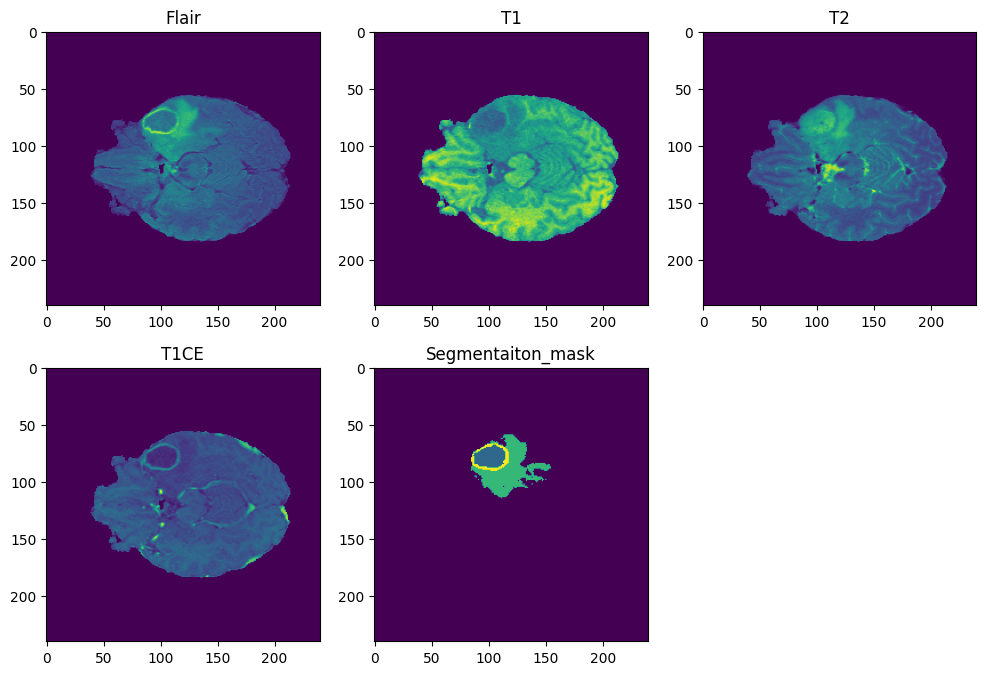

In [78]:
#Plotting the images
#As each image is a 3d image, we'll select a slice randomly (n=50)
plt.figure(figsize=(12,8))
n=50
plt.subplot(231)
plt.imshow(img_1[:,:,n])
plt.title('Flair')

plt.subplot(232)
plt.imshow(img_2[:,:,n])
plt.title('T1')

plt.subplot(233)
plt.imshow(img_3[:,:,n])
plt.title('T2')

plt.subplot(234)
plt.imshow(img_4[:,:,n])
plt.title('T1CE')

plt.subplot(235)
plt.imshow(img_5[:,:,n])
plt.title('Segmentaiton_mask')
plt.show()
#We can see the actual labelled area is very less, thus we need to crop the image


In [79]:
#For training we will combine all the 4 channels which will be the input to the CNN
X=np.stack([img_1, img_2,img_3,img_4], axis=3)
print(X.shape)
#We need to crop, cause most of the data is redundant (having label 0)
X=X[50:184, 50:184, 13:141]#Crop image is 128x128x128x4
img_5=img_5[56:184, 56:184, 13:141]

(240, 240, 155, 4)


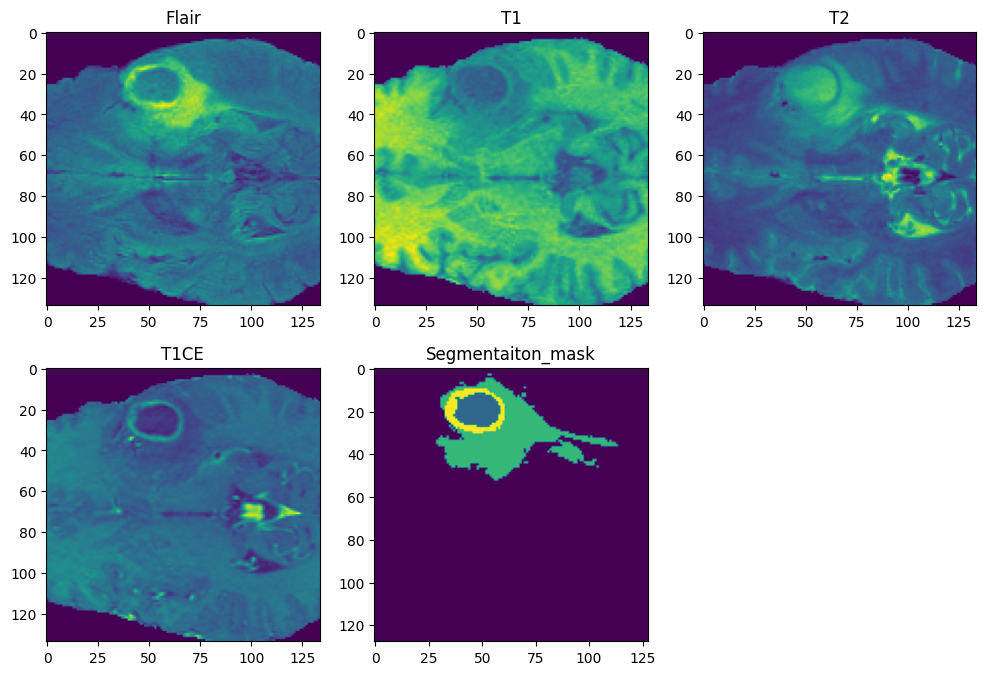

In [80]:
plt.figure(figsize=(12,8))
n=50
plt.subplot(231)
plt.imshow(X[:,:,n,0])
plt.title('Flair')

plt.subplot(232)
plt.imshow(X[:,:,n,1])
plt.title('T1')

plt.subplot(233)
plt.imshow(X[:,:,n,2])
plt.title('T2')

plt.subplot(234)
plt.imshow(X[:,:,n,3])
plt.title('T1CE')

plt.subplot(235)
plt.imshow(img_5[:,:,n])
plt.title('Segmentaiton_mask')
plt.show()

In [81]:
#We have to convert the seg_mask as categorical to train the CNNs
print(img_5.shape)
img_5=to_categorical(img_5, num_classes=4)
print(img_5.shape)#The output is now one hot encoded 

(128, 128, 128)
(128, 128, 128, 4)


In [82]:
t1_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob(r'C:\Users\yashv\Downloads\BraTS2020_TrainingData (1)\MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
print(len(t1_list),len(t2_list),len(t1ce_list),len(flair_list),len(mask_list))

369 369 369 369 369


In [94]:
for img in range(len(t1_list)):
    print(img)
    temp_image_t1=nib.load(t1_list[img]).get_fdata()
    temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
    
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3

    combined_images = np.stack([temp_image_t1,temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_combined_images=combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        #print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(r'C:/Users/yashv/Downloads/BraTS2020_TrainingData (1)/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save(r'C:/Users/yashv/Downloads/BraTS2020_TrainingData (1)/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")  

0
1
2
3
4
I am useless
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
I am useless
28
29
30
31
32
33
34
35
I am useless
36
37
38
39
40
41
42
43
I am useless
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
I am useless
61
62
I am useless
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
I am useless
79
80
81
I am useless
82
83
84
85
I am useless
86
87
88
89
90
91
92
93
94
95
96
97
98
I am useless
99
100
101
102
103
104
105
106
107
I am useless
108
109
I am useless
110
111
112
113
114
115
116
117
118
119
120
121
I am useless
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
I am useless
139
140
141
I am useless
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
I am useless
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
I am useless
204
205
206
207
208
209
210
211
212
213
214
215
216
I am useless
217
218
